In [9]:
# this notebook is a demo how to build a hp, hc surrogate for the hp and hc polarisations
# of non-spinning binaries

In [10]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size':16})

In [11]:
import datetime
import os
import numpy as np
import math

import waveform
import sample
import model_utils
import dataset

In [12]:
import tensorflow as tf

In [13]:
import pycbc.pnutils

In [14]:
import lalsimulation as lalsim

In [15]:
plt.rcParams.update({'font.size':16})

# generate waveform data

In [103]:
def gen_waveform_set(train_test_val, n_samples, nproc=1, mass_ratio_low=1, mass_ratio_high=1.2):
    assert train_test_val in ['train', 'val']
    
    # approximant="IMRPhenomXHM"
    approximant="IMRPhenomXAS"

    # uniform spacing throughout
    # t1 = -2000
    # t1 = -500
    # t1 = -200
    t1 = -50
    t2 = 70
    dt = 0.25
    new_times_M = np.arange(t1, t2, dt)

    t_idxs = np.arange(len(new_times_M))
    # t_training_idxs = None
    # t_validation_idxs = None
    if train_test_val == "train":
        t_idxs_sample = t_idxs[::2]
    elif train_test_val == "val":
        # t_idxs_sample = t_idxs[1::2]
        t_idxs_sample = t_idxs[::2]

    total_mass=100
    distance_mpc=1
    delta_t=1/4096
    f_lower=10
    
    out = sample.draw_mass_ratio_inc_coa_phase_samples(n_samples, mass_ratio_low, mass_ratio_high)
    mass_ratios = out[0]
    spin1xs = out[1]
    spin1ys = out[2]
    spin1zs = out[3]
    spin2xs = out[4]
    spin2ys = out[5]
    spin2zs = out[6]
    coa_phases = out[7]
    inclinations = out[8]

    starttime = datetime.datetime.now()

    times, thetas, hps, hcs = waveform.generate_waveforms_mp(
        new_times_M,
        mass_ratios,
        spin1xs,
        spin1ys,
        spin1zs,
        spin2xs,
        spin2ys,
        spin2zs,
        coa_phases,
        inclinations,
        time_idxs=t_idxs_sample,
        total_mass=total_mass,
        approximant=approximant,
        distance_mpc=distance_mpc,
        delta_t=delta_t,
        f_lower=f_lower,
        nproc=nproc,
    )

    endtime = datetime.datetime.now()
    duration = endtime - starttime
    print(f"The time cost: {duration}")
    

    return times, thetas, hps, hcs

In [112]:
train_times, train_thetas, train_hps, train_hcs = gen_waveform_set(train_test_val='train', n_samples=10000, nproc=8)

The time cost: 0:00:17.934938


In [113]:
train_thetas.shape

(10000, 9)

In [114]:
# train_thetas[:,[0,7,8]]

In [115]:
val_times, val_thetas, val_hps, val_hcs = gen_waveform_set(train_test_val='val', n_samples=100, nproc=4)

The time cost: 0:00:00.345389


Text(0, 0.5, 'inclination')

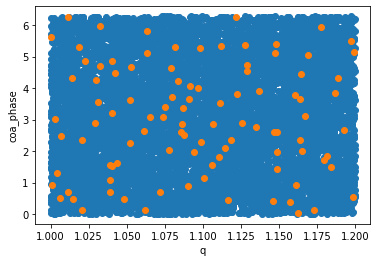

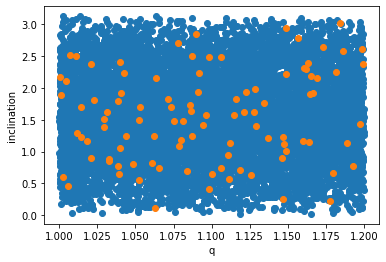

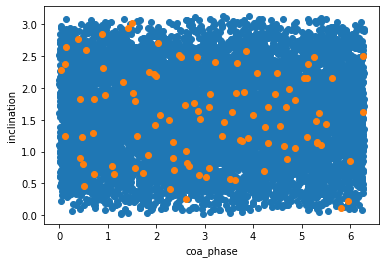

In [116]:
plt.figure()
plt.scatter(train_thetas[:,0], train_thetas[:,7])
plt.scatter(val_thetas[:,0], val_thetas[:,7])
plt.xlabel('q')
plt.ylabel('coa_phase')

plt.figure()
plt.scatter(train_thetas[:,0], train_thetas[:,8])
plt.scatter(val_thetas[:,0], val_thetas[:,8])
plt.xlabel('q')
plt.ylabel('inclination')

plt.figure()
plt.scatter(train_thetas[:,7], train_thetas[:,8])
plt.scatter(val_thetas[:,7], val_thetas[:,8])
plt.xlabel('coa_phase')
plt.ylabel('inclination')

# fit model

In [117]:
m1,m2 = pycbc.pnutils.mchirp_q_to_mass1_mass2(100, 2)
m1,m2

(164.3751829517226, 82.18759147586127)

time_b_scale: 0.033746332745444245
theta_b_scale: 0.1
theta_input_shape: 9
making traing dataset
making validation dataset
total_number_of_points (training): 2400000
steps_per_epoch: 18750


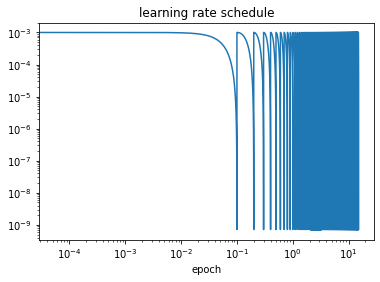

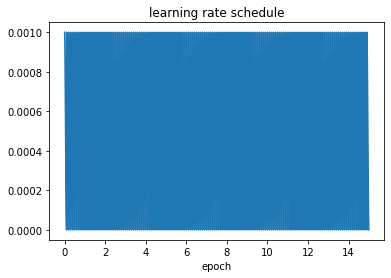

In [194]:
epochs = 15
#batch_size = 1024
# batch_size = 512
batch_size = 128
# batch_size = 32

# f_rd_mf = waveform.HztoMf(pycbc.pnutils._get_final_freq(approx=lalsim.SEOBNRv4, m1=75, m2=25, s1z=0.99, s2z=0.99), 100)

f_rd_mf = waveform.HztoMf(pycbc.pnutils._get_final_freq(approx=lalsim.SEOBNRv4, m1=m1, m2=m2, s1z=0., s2z=0.), 100)

time_b_scale = f_rd_mf
print(f"time_b_scale: {time_b_scale}")

# theta_b_scale = 1
# theta_b_scale = 0.5
# theta_b_scale = 10
theta_b_scale = 0.1
print(f"theta_b_scale: {theta_b_scale}")

theta_input_shape = train_thetas.shape[1]
print(f"theta_input_shape: {theta_input_shape}")

print("making traing dataset")
train_ds = dataset.DataGen(thetas=train_thetas, times=train_times, ys=train_hps, batch_size=batch_size, shuffle=True)

# del train_thetas, train_times, train_hps

print("making validation dataset")
val_ds = dataset.DataGen(thetas=val_thetas, times=val_times, ys=val_hps, batch_size=batch_size, shuffle=False) 

# del val_thetas, val_times, val_hps

total_number_of_points = train_ds.total_number_of_points
print(f"total_number_of_points (training): {total_number_of_points}")



# https://www.tensorflow.org/addons/tutorials/optimizers_cyclicallearningrate
# epochs=104
# batch_size=32
# steps_per_epoch = len(X_train) // batch_size
steps_per_epoch = math.ceil(total_number_of_points / batch_size)
# steps_per_epoch is the number of mini-batches per epoch
print(f"steps_per_epoch: {steps_per_epoch}")

# https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules/CosineDecayRestarts1
lrs = tf.keras.optimizers.schedules.CosineDecayRestarts(
    1e-3,
    # 500*5,
    # 5,
    steps_per_epoch/10,
    # t_mul=2.0,
    t_mul=1.,
    m_mul=1.,
    alpha=0.0,
    name=None
)


step = np.arange(0, epochs * steps_per_epoch)
lr_ = lrs(step)

plt.figure()
plt.plot(step/steps_per_epoch, lr_)
plt.xlabel("epoch")
plt.title("learning rate schedule")
plt.yscale('log')
plt.xscale('log')
plt.show()
plt.close()

plt.figure()
plt.plot(step/steps_per_epoch, lr_)
plt.xlabel("epoch")
plt.title("learning rate schedule")
# plt.yscale('log')
# plt.xscale('log')
plt.show()
plt.close()



In [ ]:
starttime = datetime.datetime.now()

history, model = model_utils.run_model_ds(
    train_ds=train_ds,
    time_b_scale=time_b_scale,
    theta_b_scale=theta_b_scale,
    theta_input_shape=theta_input_shape,
    epochs=epochs,
    threshold=1e-7,
    validation_data=val_ds,
    verbose=1,
    learning_rate=lrs,
)

endtime = datetime.datetime.now()
duration = endtime - starttime
print(f"The time cost: {duration}")

Epoch 1/15
    1/18750 [..............................] - ETA: 1:55:32 - loss: 0.1112

2022-07-07 01:09:53.043278: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18744/18750 [============================>.] - ETA: 0s - loss: 7.0239e-04

2022-07-07 01:12:03.763868: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18750/18750 [==============================] - 132s 7ms/step - loss: 7.0220e-04 - val_loss: 1.8462e-04
Epoch 2/15
18750/18750 [==============================] - 132s 7ms/step - loss: 2.1428e-04 - val_loss: 9.3433e-05
Epoch 3/15
18750/18750 [==============================] - 131s 7ms/step - loss: 1.6677e-04 - val_loss: 7.8701e-05
Epoch 4/15
 6803/18750 [=========>....................] - ETA: 1:22 - loss: 1.5437e-04

In [ ]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.yscale('log')

# eval model

In [ ]:
def build_input_single(t, *args):
    """
    t is a matrix i.e. shape = (-1, 1)
    list of parameters
    """
    theta = np.array([*args])
    theta = np.ones_like(t) * theta

    return np.column_stack((t, theta))

In [ ]:
def build_input_multiple(t, thetas):
    """
    t is a vector
    thetas is a vector
    """
    return np.row_stack([build_input_single(t, *theta) for theta in thetas])

In [ ]:
n_waveforms = val_thetas.shape[0]
n_times = val_times.shape[0]

In [ ]:
Xval = build_input_multiple(val_times, val_thetas)

In [ ]:
yhats_val = model([Xval[:,0], Xval[:,1:]])
yhats_val = yhats_val.numpy()
yhats_val = yhats_val.reshape(n_waveforms, n_times)

In [ ]:
yhats_val.shape

In [ ]:
mses = tf.keras.losses.mse(yhats_val, val_hps).numpy()

In [ ]:
print(mses.min())
print(mses.max())
print(mses.mean())

In [ ]:
worst_index = mses.argmax()

In [ ]:
val_thetas[worst_index]

In [ ]:
#worst
plt.figure()
plt.plot(val_times, val_hps[worst_index])
plt.plot(val_times, yhats_val[worst_index])
# plt.xlim(-100, 100)

In [ ]:
# best
plt.figure()
plt.plot(val_times, val_hps[mses.argmin()])
plt.plot(val_times, yhats_val[mses.argmin()])
# plt.xlim(-100, 100)

In [ ]:
plt.figure()
plt.scatter(val_thetas[:,0], val_thetas[:,7], c=mses)
plt.xlabel('q')
plt.ylabel('coa_phase')

plt.figure()
plt.scatter(val_thetas[:,0], val_thetas[:,8], c=mses)
plt.xlabel('q')
plt.ylabel('inclination')

plt.figure()
plt.scatter(val_thetas[:,7], val_thetas[:,8], c=mses)
plt.xlabel('coa_phase')
plt.ylabel('inclination')

In [ ]:
plt.figure()
plt.scatter(train_thetas[:,0], train_thetas[:,7])
plt.scatter(val_thetas[:,0], val_thetas[:,7], c=mses)
plt.xlabel('q')
plt.ylabel('coa_phase')

plt.figure()
plt.scatter(train_thetas[:,0], train_thetas[:,8])
plt.scatter(val_thetas[:,0], val_thetas[:,8], c=mses)
plt.xlabel('q')
plt.ylabel('inclination')

plt.figure()
plt.scatter(train_thetas[:,7], train_thetas[:,8])
plt.scatter(val_thetas[:,7], val_thetas[:,8], c=mses)
plt.xlabel('coa_phase')
plt.ylabel('inclination')

In [ ]:
for yhat_val in yhats_val[:10]:
    plt.plot(val_times, yhat_val)